In [3]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt


def load_dataset():
    mndata = MNIST('./data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return X_train, labels_train, X_test, labels_test

In [6]:
X_train_mult, labels_train_mult, X_test_mult, labels_test_mult = load_dataset()

In [44]:
#take only binary for 2 and 7
idx_2_7 = (labels_train_mult == 2).astype('int') + (labels_train_mult == 7).astype('int')
X_train = X_train_mult[idx_2_7.astype('bool')].astype('float')
y_train = labels_train_mult[idx_2_7.astype('bool')].astype('float')
y_train[y_train == 7] = 1
y_train[y_train == 2] = -1

In [45]:
y_train

array([-1.,  1., -1., ..., -1.,  1., -1.])

In [46]:
idx_2_7_test = (labels_test_mult == 2).astype('int') + (labels_test_mult == 7).astype('int')
X_test = X_test_mult[idx_2_7_test.astype('bool')].astype('float')
y_test = labels_test_mult[idx_2_7_test.astype('bool')].astype('float')
y_test[y_test == 7] = 1
y_test[y_test == 2] = -1

In [48]:
X_test.shape, y_test.shape, X_test_mult.shape

((2060, 784), (2060,), (10000, 784))

In [102]:
def accuracy_error(y_true, y_pred):
    """
    Trains ridge regression using closed-form solution

    Parameters
    ----------
    y_true : np.array of shape (m,)
        Vector of true labels
    y_pred : np.array of shape (m,)
        Vector of predicted labels
    
    Returns
    -------
    float
        error: 1-accuracy
    """
    return 1-np.mean(y_true == y_pred)

def mu(w, b, X, y):
    return 1/(1+np.exp(-y*(b + X.dot(w))))

def grad_w(w, b, X, y, reg_lambda):
    return np.mean(((mu(w, b, X, y) - 1)*y)[:,None]*X, axis = 0) +2*reg_lambda*w

def grad_b(w, b, X, y):
    return np.mean((mu(w, b, X, y) - 1)*y, axis = 0) 

def J(w, b, X, y, reg_lambda = 0.1):
    return np.mean(np.log(1+np.exp(-y*(b + X.dot(w))))) + reg_lambda*w.dot(w)

In [105]:
def grad_descent(step, X, y, reg_lambda = 0.1, w_init = None, b_init = None, max_iter = 10000):
    n, d = X.shape
    if w_init is None:
        w_init = np.zeros(d)
    if b_init is None:
        b_init = 0
    count = 0
    w = w_init
    b = b_init
    w_prev = w_init + np.inf
    conv_history = []
    w_history = []
    b_history = []
    while np.linalg.norm(w - w_prev, np.inf) >= 1e-4 and count <= max_iter:
        count += 1
        w_prev = np.copy(w)
        w = w - step*grad_w(w, b, X, y, reg_lambda)
        b = b - step*grad_b(w, b, X, y)
        conv_history.append(J(w, b, X, y, reg_lambda))
        w_history.append(w)
        b_history.append(b)
        if count%10 == 0:
            print('Iter ', count, 'Loss: ', conv_history[-1])
    return w, b, conv_history, w_history, b_history

In [116]:
def predict(w, b, X):
    return np.sign(b + X.dot(w))

In [106]:
w, b, conv_history, w_history, b_history = grad_descent(0.1, X_train, y_train, reg_lambda = 0.1, w_init = None, b_init = None, max_iter = 10000)

Iter  10 Loss:  0.26910212128149835
Iter  20 Loss:  0.24307356513167044
Iter  30 Loss:  0.23767939373136204
Iter  40 Loss:  0.23606594394298533
Iter  50 Loss:  0.23544698073788034
Iter  60 Loss:  0.23515367115848643
Iter  70 Loss:  0.23498776145656275


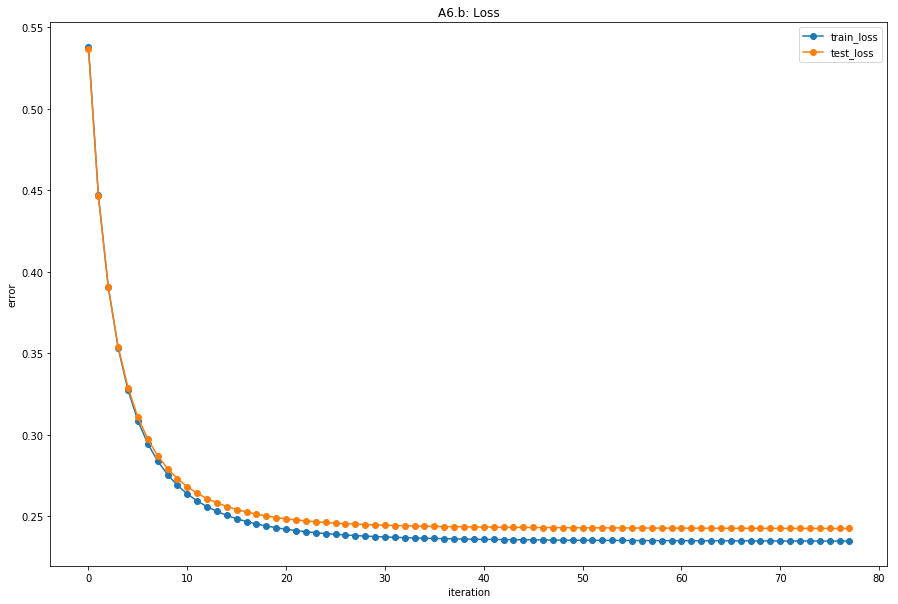

In [115]:
#Part b1
train_loss = conv_history
test_loss = [J(w, b, X_test, y_test, reg_lambda = 0.1) for w, b in zip(w_history, b_history)]

plt.figure(figsize = (15,10))
plt.plot(train_loss, '-o', label = 'train_loss')
plt.plot(test_loss, '-o', label = 'test_loss')
plt.title('A6.b: Loss')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('error')
plt.savefig('figures/A6b1.pdf')
plt.show()

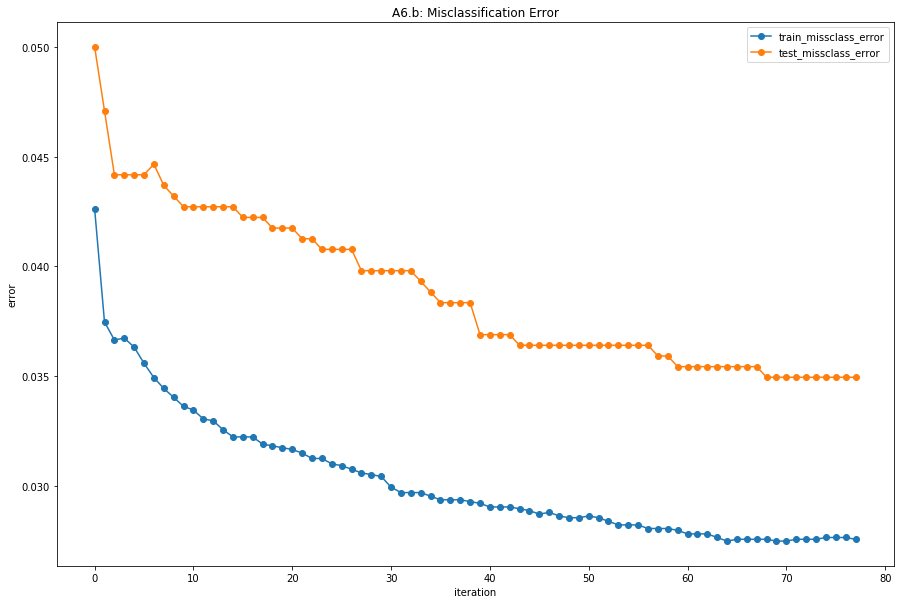

In [119]:
#Part b2
y_pred_train = [predict(w, b, X_train) for w, b in zip(w_history, b_history)]
train_missclass_error = [accuracy_error(y_train, y_pred) for y_pred in y_pred_train]

y_pred_test = [predict(w, b, X_test) for w, b in zip(w_history, b_history)]
test_missclass_error = [accuracy_error(y_test, y_pred) for y_pred in y_pred_test]

plt.figure(figsize = (15,10))
plt.plot(train_missclass_error, '-o', label = 'train_missclass_error')
plt.plot(test_missclass_error, '-o', label = 'test_missclass_error')
plt.title('A6.b: Misclassification Error')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('error')
plt.savefig('figures/A6b2.pdf')
plt.show()

In [140]:
def SGD(step, batch_size, X, y, reg_lambda = 0.1, w_init = None, b_init = None, max_iter = 10000):
    n, d = X.shape
    if w_init is None:
        w_init = np.zeros(d)
    if b_init is None:
        b_init = 0
    count = 0
    w = w_init
    b = b_init
    w_prev = w_init + np.inf
    conv_history = []
    w_history = []
    b_history = []
    while np.linalg.norm(w - w_prev, np.inf) >= 1e-4 and count <= max_iter:
        #Sample random batch:
        batch_idx = np.random.choice(n, batch_size)
        X_batch = X[batch_idx]
        y_batch = y[batch_idx]
        
        count += 1
        w_prev = np.copy(w)
        w = w - step*grad_w(w, b, X_batch, y_batch, reg_lambda)
        b = b - step*grad_b(w, b, X_batch, y_batch)
        conv_history.append(J(w, b, X, y, reg_lambda))
        w_history.append(w)
        b_history.append(b)
        if count%10 == 0:
            print('Iter ', count, 'Loss: ', conv_history[-1])
    return w, b, conv_history, w_history, b_history

In [144]:
w, b, conv_history, w_history, b_history = SGD(step = 0.01, batch_size = 1, X = X_train, y = y_train, max_iter = 500)

Iter  10 Loss:  0.5880685174847833
Iter  20 Loss:  0.46426684723789174
Iter  30 Loss:  0.42769048817494787
Iter  40 Loss:  0.37824315260405883
Iter  50 Loss:  0.34247112960403964
Iter  60 Loss:  0.33983598970800516
Iter  70 Loss:  0.30449811198572474
Iter  80 Loss:  0.2929313203121011
Iter  90 Loss:  0.28452948898869945
Iter  100 Loss:  0.3127854428247169
Iter  110 Loss:  0.3063841004909492
Iter  120 Loss:  0.26691831860331805
Iter  130 Loss:  0.26292127677312804
Iter  140 Loss:  0.25787038906670406
Iter  150 Loss:  0.2571894812422327
Iter  160 Loss:  0.256972912294983
Iter  170 Loss:  0.2578654792409978
Iter  180 Loss:  0.2523743807073532
Iter  190 Loss:  0.25642487608778836
Iter  200 Loss:  0.2572187920465759
Iter  210 Loss:  0.25211604904535906
Iter  220 Loss:  0.24842298856640926
Iter  230 Loss:  0.24701640664780494
Iter  240 Loss:  0.24416203620664584
Iter  250 Loss:  0.2439622782307385
Iter  260 Loss:  0.24474780772446117
Iter  270 Loss:  0.24263000925012582
Iter  280 Loss:  0.24

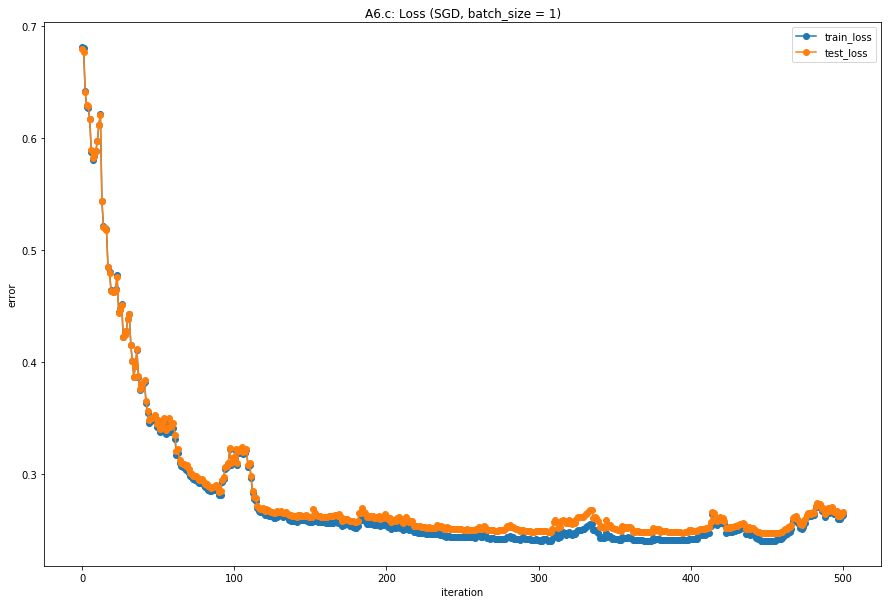

In [146]:
#Part c1
train_loss = conv_history
test_loss = [J(w, b, X_test, y_test, reg_lambda = 0.1) for w, b in zip(w_history, b_history)]

plt.figure(figsize = (15,10))
plt.plot(train_loss, '-o', label = 'train_loss')
plt.plot(test_loss, '-o', label = 'test_loss')
plt.title('A6.c: Loss (SGD, batch_size = 1)')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('error')
plt.savefig('figures/A6c1.pdf')
plt.show()

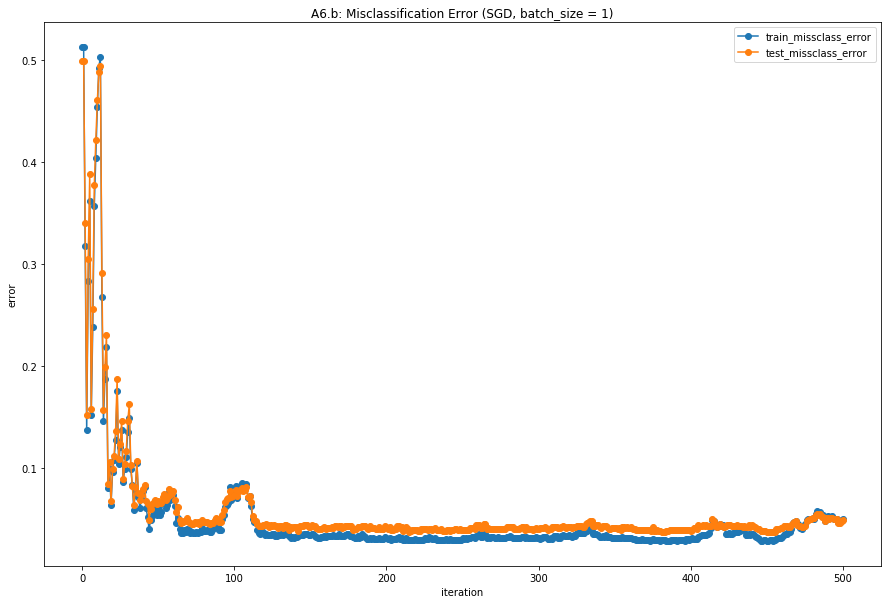

In [147]:
#Part c2
y_pred_train = [predict(w, b, X_train) for w, b in zip(w_history, b_history)]
train_missclass_error = [accuracy_error(y_train, y_pred) for y_pred in y_pred_train]

y_pred_test = [predict(w, b, X_test) for w, b in zip(w_history, b_history)]
test_missclass_error = [accuracy_error(y_test, y_pred) for y_pred in y_pred_test]

plt.figure(figsize = (15,10))
plt.plot(train_missclass_error, '-o', label = 'train_missclass_error')
plt.plot(test_missclass_error, '-o', label = 'test_missclass_error')
plt.title('A6.b: Misclassification Error (SGD, batch_size = 1)')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('error')
plt.savefig('figures/A6c2.pdf')
plt.show()

In [148]:
w, b, conv_history, w_history, b_history = SGD(step = 0.01, batch_size = 100, X = X_train, y = y_train, max_iter = 500)

Iter  10 Loss:  0.5499706664162034
Iter  20 Loss:  0.4611987142137493
Iter  30 Loss:  0.40430785506907885
Iter  40 Loss:  0.3657044206655451
Iter  50 Loss:  0.3380215236533402
Iter  60 Loss:  0.317957608858976
Iter  70 Loss:  0.3024006641696935
Iter  80 Loss:  0.29041868610876626
Iter  90 Loss:  0.28115460120352104
Iter  100 Loss:  0.2737757197452456
Iter  110 Loss:  0.2679098622524193
Iter  120 Loss:  0.26330695519610503
Iter  130 Loss:  0.2591270193233811
Iter  140 Loss:  0.2557449978529656
Iter  150 Loss:  0.2531370897575059
Iter  160 Loss:  0.25086188860652614
Iter  170 Loss:  0.24886120524912367
Iter  180 Loss:  0.24717051067909046
Iter  190 Loss:  0.24568515393531137
Iter  200 Loss:  0.24434509455671874
Iter  210 Loss:  0.24337995168512527
Iter  220 Loss:  0.24240797712576215
Iter  230 Loss:  0.2416594235687531
Iter  240 Loss:  0.24091277384969212
Iter  250 Loss:  0.2403151673731617
Iter  260 Loss:  0.23976995285567243
Iter  270 Loss:  0.2393468711427682
Iter  280 Loss:  0.238858

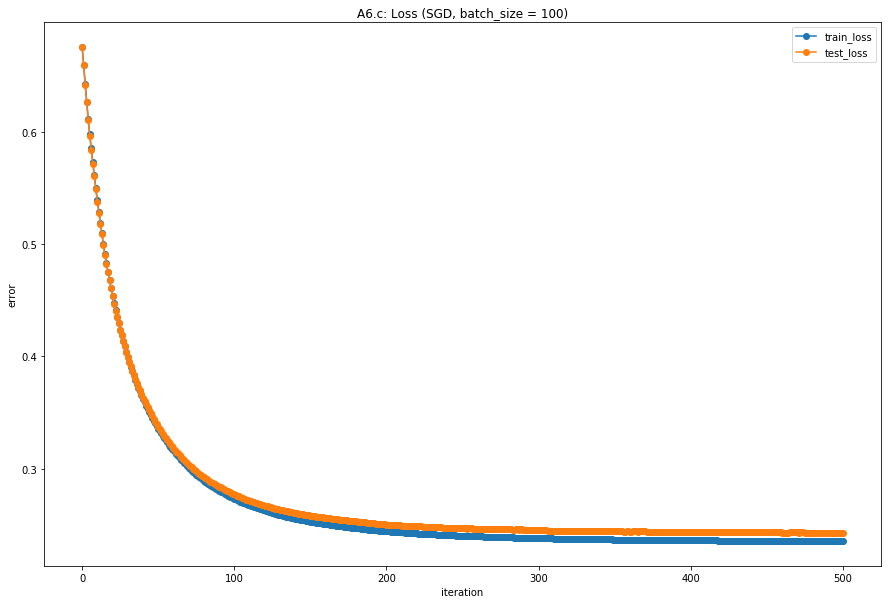

In [149]:
#Part d1
train_loss = conv_history
test_loss = [J(w, b, X_test, y_test, reg_lambda = 0.1) for w, b in zip(w_history, b_history)]

plt.figure(figsize = (15,10))
plt.plot(train_loss, '-o', label = 'train_loss')
plt.plot(test_loss, '-o', label = 'test_loss')
plt.title('A6.c: Loss (SGD, batch_size = 100)')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('error')
plt.savefig('figures/A6d1.pdf')
plt.show()

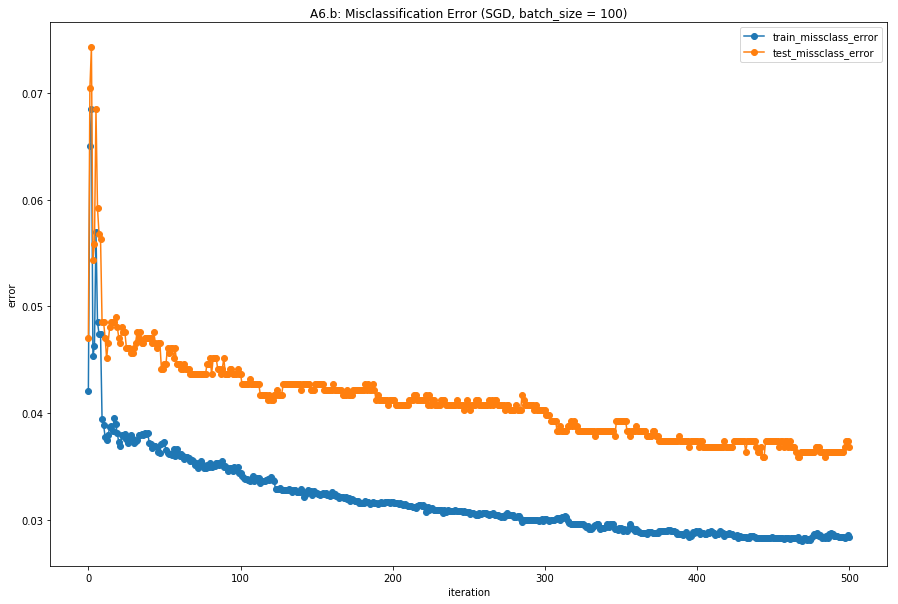

In [150]:
#Part c2
y_pred_train = [predict(w, b, X_train) for w, b in zip(w_history, b_history)]
train_missclass_error = [accuracy_error(y_train, y_pred) for y_pred in y_pred_train]

y_pred_test = [predict(w, b, X_test) for w, b in zip(w_history, b_history)]
test_missclass_error = [accuracy_error(y_test, y_pred) for y_pred in y_pred_test]

plt.figure(figsize = (15,10))
plt.plot(train_missclass_error, '-o', label = 'train_missclass_error')
plt.plot(test_missclass_error, '-o', label = 'test_missclass_error')
plt.title('A6.b: Misclassification Error (SGD, batch_size = 100)')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('error')
plt.savefig('figures/A6d2.pdf')
plt.show()